In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_df = pd.read_csv("./Data/PetFinder_dataset.csv")
print(raw_df.PetID.is_unique)
raw_df = pd.read_csv("./Data/PetFinder_dataset.csv", index_col='PetID')

True


## Working with Data

#### Data visualization

In [3]:
raw_df.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [4]:
raw_df.drop(columns='Description').head() # hiding Description column for convenience

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,Nibble,3,299,0,1,1,7,0,1,...,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,1.0,2
6296e909a,2,No Name Yet,1,265,0,1,1,2,0,2,...,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,2.0,0
3422e4906,1,Brisco,1,307,0,1,2,7,0,2,...,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,7.0,3
5842f1ff5,1,Miko,4,307,0,2,1,2,0,2,...,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,8.0,2
850a43f90,1,Hunter,1,307,0,1,1,0,0,2,...,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,3.0,2


In [5]:
# Checking Description alone.
for PetID, Description in raw_df[['Description']].head().iterrows(): # using iterrows instead of iloc because we need access to the pair PetID: Description  
    print(f"<{PetID}> {Description.values[0]}")                  # iloc doesn't pair the Index with the data, instead only check the position.

<86e1089a3> Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.
<6296e909a> I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.
<3422e4906> Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.
<5842f1ff5> Good guard dog, very alert, active, obedience waiting for her good master, plz 

##### Checking Data Distribution

In [6]:
# lets start by dropping columns that are't relevant for this analysis.

visual_df = raw_df.drop(columns=['Name', 'RescuerID', 'Description'])
visual_df.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,2
6296e909a,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,0
3422e4906,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,3
5842f1ff5,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,2
850a43f90,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,2


In [7]:
# Now lets take a look at the data distribution in our df

for column in visual_df.columns:
    print(visual_df[column].value_counts())

Type
1    8132
2    6861
Name: count, dtype: int64
Age
2      3503
1      2304
3      1966
4      1109
12      967
       ... 
69        1
74        1
81        1
44        1
100       1
Name: count, Length: 106, dtype: int64
Breed1
307    5927
266    3634
265    1258
299     342
264     296
       ... 
176       1
214       1
125       1
123       1
81        1
Name: count, Length: 176, dtype: int64
Breed2
0      10762
307     1727
266      599
265      321
299      138
       ...  
104        1
36         1
17         1
257        1
279        1
Name: count, Length: 135, dtype: int64
Gender
2    7277
1    5536
3    2180
Name: count, dtype: int64
Color1
1    7427
2    3750
3     947
5     884
6     684
7     667
4     634
Name: count, dtype: int64
Color2
0    4471
7    3438
2    3313
5    1128
6    1063
4     870
3     710
Name: count, dtype: int64
Color3
0    10604
7     3221
5      417
6      378
4      198
3      175
Name: count, dtype: int64
MaturitySize
2    10305
1     3395
3   

array([[<Axes: title={'center': 'Type'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Breed1'}>,
        <Axes: title={'center': 'Breed2'}>],
       [<Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Color1'}>,
        <Axes: title={'center': 'Color2'}>,
        <Axes: title={'center': 'Color3'}>],
       [<Axes: title={'center': 'MaturitySize'}>,
        <Axes: title={'center': 'FurLength'}>,
        <Axes: title={'center': 'Vaccinated'}>,
        <Axes: title={'center': 'Dewormed'}>],
       [<Axes: title={'center': 'Sterilized'}>,
        <Axes: title={'center': 'Health'}>,
        <Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'Fee'}>],
       [<Axes: title={'center': 'State'}>,
        <Axes: title={'center': 'VideoAmt'}>,
        <Axes: title={'center': 'PhotoAmt'}>,
        <Axes: title={'center': 'AdoptionSpeed'}>]], dtype=object)

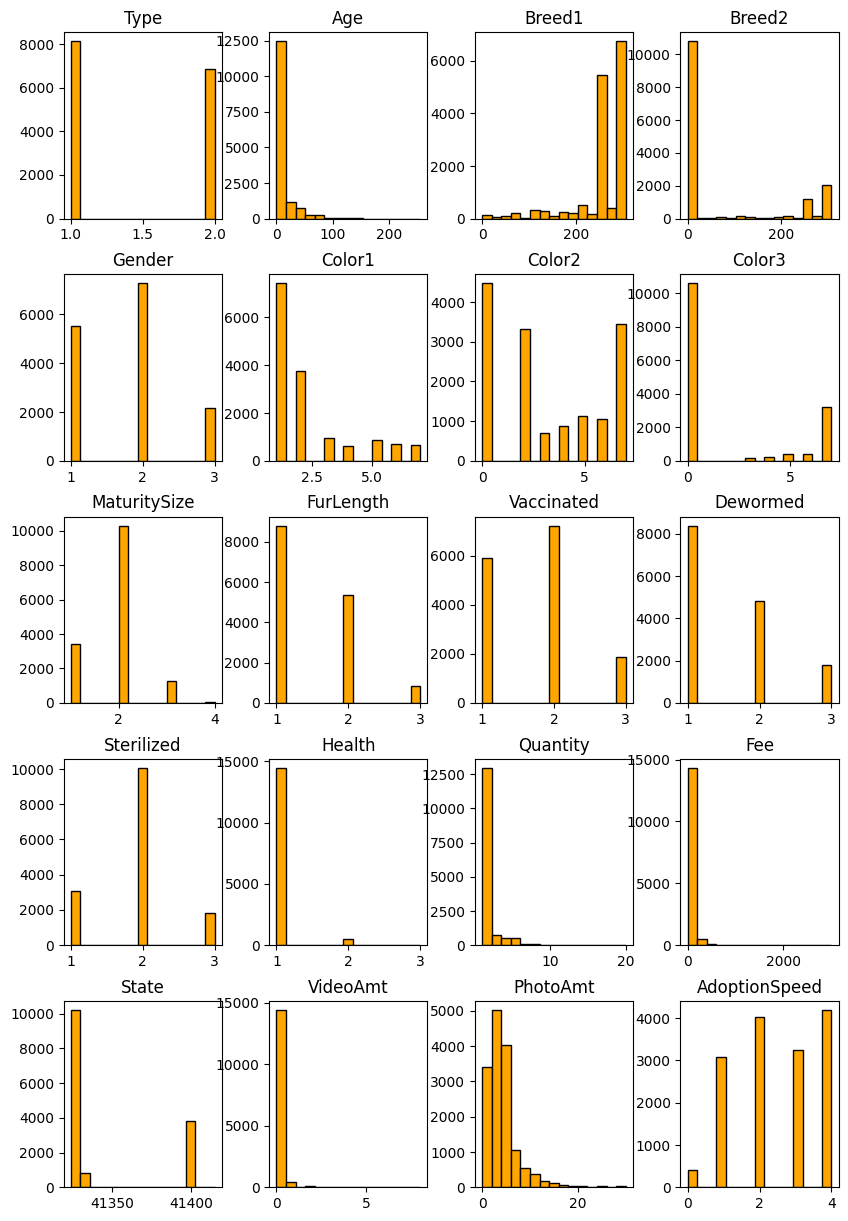

In [8]:
visual_df.hist(figsize=[10,15],bins=15, color='orange', histtype='bar', ec='black', grid=False)

In [9]:
visual_df.isnull().sum()

Type             0
Age              0
Breed1           0
Breed2           0
Gender           0
Color1           0
Color2           0
Color3           0
MaturitySize     0
FurLength        0
Vaccinated       0
Dewormed         0
Sterilized       0
Health           0
Quantity         0
Fee              0
State            0
VideoAmt         0
PhotoAmt         0
AdoptionSpeed    0
dtype: int64

#### Feature Engineering

##### Splitting the animal type into 2 dfs

In [10]:
# 1. split the data in 2 dataframes, one for cats and one for dogs.
def feature_filter(row, value):
    """  
    feature_filter: Checks a row in a df and returns it target_feature = value
    """
    if row == value:
        return value
    else:
        return None

df_dogs = raw_df.copy()
df_dogs['Type'] = df_dogs['Type'].apply(lambda row: feature_filter(row, 1))
df_cats = raw_df.copy()
df_cats['Type'] = df_cats['Type'].apply(lambda row: feature_filter(row, 2))

print(raw_df['Type'].value_counts())
print(f"Removed {df_dogs['Type'].isnull().sum()} rows for dogs_df")
print(f"Removed {df_cats['Type'].isnull().sum()} rows for cats_df")

df_dogs = df_dogs.dropna()
df_cats = df_cats.dropna()

Type
1    8132
2    6861
Name: count, dtype: int64
Removed 6861 rows for dogs_df
Removed 8132 rows for cats_df


##### Adding new feature: isPureBreed
- checks whether the animal has a single breed or not

In [11]:
def Breed2_Cleaner(row): # if both breeds are the same, it doesn't have a second breed.
    if row['Breed1'] == row['Breed2']:
        row['Breed2'] = 0
    return row

def set_isPureBreed(row):
    if row['Breed2'] != 0:
        return False
    elif row['Breed1'] == 307: # code for mixed breed
        return False
    else: return True

###### isPureBreed: Cat Data

In [12]:
df_cats['Breed2'].value_counts().head()

Breed2
0      4641
266     555
265     306
299     126
264     116
Name: count, dtype: int64

In [13]:
df_cats = df_cats.apply(Breed2_Cleaner, axis=1)

In [14]:
df_cats['Breed2'].value_counts().head() # we can see that there are now more "0" values, which means the function is working.

Breed2
0      5035
266     313
265     226
299     120
264      99
Name: count, dtype: int64

In [15]:
df_cats['isPureBreed'] = df_cats.apply(set_isPureBreed, axis=1)

###### isPureBreed: Dog Data

In [16]:
df_dogs = df_dogs.apply(Breed2_Cleaner, axis=1)
df_dogs['isPureBreed'] = df_dogs.apply(set_isPureBreed, axis=1)


###### isPureBreed: Results

In [17]:
print('Pure Bred Cats count:')
print(df_cats['isPureBreed'].value_counts(), '\n')
print('Pure Bred Dogs count:')
print(df_dogs['isPureBreed'].value_counts())

Pure Bred Cats count:
isPureBreed
True     5031
False    1209
Name: count, dtype: int64 

Pure Bred Dogs count:
isPureBreed
False    6388
True     1088
Name: count, dtype: int64


In [18]:
# Interesting to note that the majority of the cats are pure-bred and the contraty happens in dogs.

##### Adding new feature: isPetAdopted

In [19]:
def set_isPetAdopted(row):
    return not row['AdoptionSpeed'] == 4

In [20]:
df_cats['isPetAdopted'] = df_cats.apply(set_isPetAdopted, axis=1)
df_cats['isPetAdopted'].value_counts()

isPetAdopted
True     4636
False    1604
Name: count, dtype: int64

In [21]:
df_cats['AdoptionSpeed'].value_counts() # by checking that in the False values are equal to the ammount of 4 values in AdoptionSpeed, we confirm that this is working

AdoptionSpeed
2    1709
4    1604
1    1506
3    1192
0     229
Name: count, dtype: int64

In [22]:
df_dogs['isPetAdopted'] = df_dogs.apply(set_isPetAdopted, axis=1)
df_dogs['isPetAdopted'].value_counts()

isPetAdopted
True     5322
False    2154
Name: count, dtype: int64

In [23]:
# is we want to merge both cats and dogs once again just uncomment this line

#complete_df = pd.concat([df_cats, df_dogs])